## Import Libraries

In [1]:
# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import clear_output

import os
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras import Model, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.applications import MobileNet
from keras.applications.densenet import DenseNet121
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub

# Little Configuration
np.set_printoptions(linewidth=np.inf)

# Mencetak versi TensorFlow yang sedang digunakan
print(f"Tensorflow Version : {tf.__version__}")
print(f"keras Version      : {keras.__version__}")
print([device for device in tf.config.list_physical_devices()][0])
print([device for device in tf.config.list_physical_devices()][1])

Tensorflow Version : 2.13.0
keras Version      : 2.13.1
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Print Bold
def bold (text):
    return "\033[1m" + str(text) + '\033[0m'

## Data Loading

In [3]:
# Linux Path
dataset_path = "/mnt/7E3A592A3A58E127/DBS/Dataset/Animal Image Dataset"

In [4]:
#  Create Animal Dictionary
animal_dict = {}
for label in os.listdir(dataset_path):
    animal_dict[label] = os.listdir(os.path.join(dataset_path, label))
# print(animal_dict['cats'])

In [19]:
# Print Dataset Info
print(f"Dataset has {bold(len(animal_dict.keys()))} labels : {[label for label in animal_dict.keys()]}")
print(f"Total Images : {bold(sum([len(value) for value in animal_dict.values()]))}")
# for key, value in animal_dict.items():
    # print("{} belongs to {}".format(bold(str(len(value))), bold(key)))

Dataset has 12 labels : ['butterfly', 'cats', 'cow', 'dogs', 'elephant', 'hen', 'horse', 'monkey', 'panda', 'sheep', 'spider', 'squirrel']
Total Images : 24000


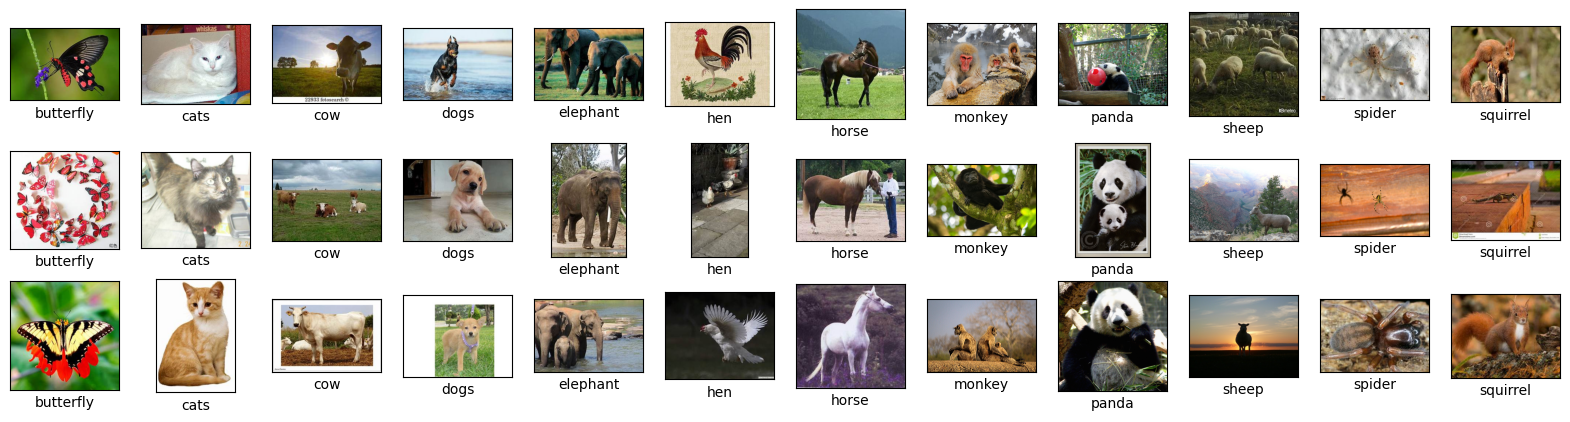

In [6]:
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(3, len(animal_dict.keys()), figsize=(20, 5))

for i, label in enumerate(animal_dict.keys()):
    images = np.random.choice(animal_dict[label], 3, replace=False)
    
    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, label, image_name)
        img = Image.open(img_path)
        axs[j, i].imshow(img)
        axs[j, i].set(xlabel=label, xticks=[], yticks=[])
# fig.tight_layout()

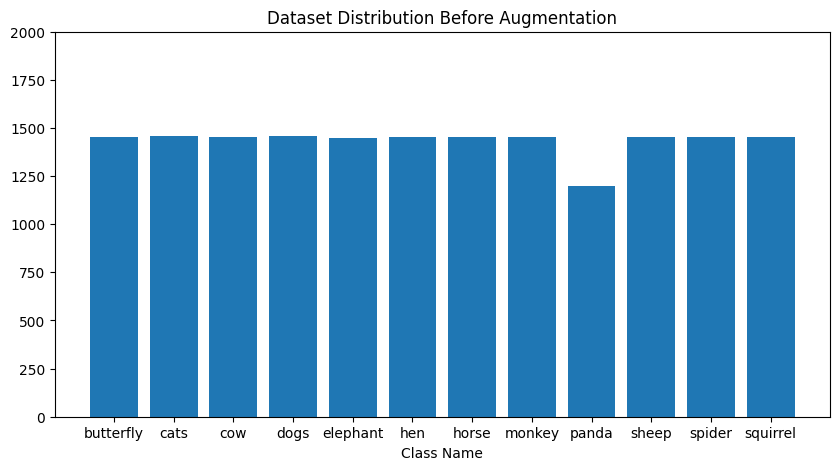

In [8]:
# Distributuin Plot
data_label, data_count = [], []
for key, value in animal_dict.items():
    data_label.append(key)
    data_count.append(len(value))
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(data_label, data_count)
ax.set_ylim(0, 2000)
ax.set_xlabel('Class Name')
ax.set_title('Dataset Distribution Before Augmentation')
plt.show()

## Data Augmentation

### Augmentation Functions

In [9]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)
 
# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)
 
# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)
 
# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img
 
# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)
 
# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image
 
# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

### Apply Augmentation

In [10]:
# Augmentation Function Dict
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

In [15]:
for key, value in animal_dict.items():
    # print(len(value), key)
    images_path = os.path.join(dataset_path, key)
    augmented_path = images_path
    images = []
    
    for image in os.listdir(images_path):
        images.append(os.path.join(images_path, image))
        
    images_to_generate = 2000
    i = len(value) + 1
    
    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)

            # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
            if original_image.ndim not in [3, 4]:
                raise ValueError('Invalid image dimensions')

            transformed_image = None
            n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
            transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

            while n <= transformation_count:
                aug_func = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
                clear_output(wait=True)
                print(key)
                print(aug_func)
                print(image)
                transformed_image = transformations[aug_func](original_image)
                n = n + 1

            new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
            transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
            cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
            i = i + 1
            time.sleep(0.05)
        except ValueError as e:
            print('Failed', aug_func, image, ':', e, 'hence skipping it.')

squirrel
warp shift
/mnt/7E3A592A3A58E127/DBS/Dataset/Animal Image Dataset/squirrel/OIP-b5GYRbxNX35PVsufsQRSGQHaI0.jpeg


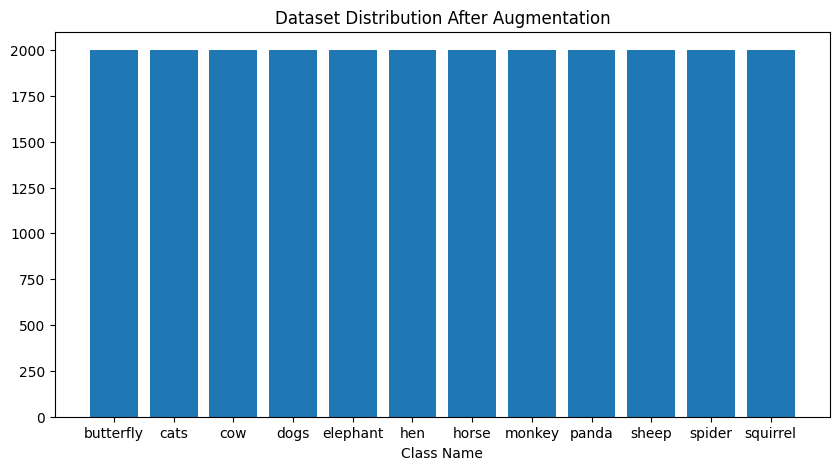

In [16]:
# Update Animal Dictionary
for label in os.listdir(dataset_path):
    animal_dict[label] = os.listdir(os.path.join(dataset_path, label))

# Distributuin Plot
data_label, data_count = [], []
for key, value in animal_dict.items():
    data_label.append(key)
    data_count.append(len(value))
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(data_label, data_count)
ax.set_xlabel('Class Name')
ax.set_title('Dataset Distribution After Augmentation')
plt.show()

## Image Data Generator

In [24]:
datagen = ImageDataGenerator(
    rescale = 1/255.,           # Normalization
    validation_split = 0.2      # Validation Split = 20%
)

X_train = datagen.flow_from_directory(
    dataset_path,
    batch_size=64,
    target_size=(224,224),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

X_valid = datagen.flow_from_directory(
    dataset_path,
    batch_size=64,
    target_size=(224,224),
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 19200 images belonging to 12 classes.
Found 4800 images belonging to 12 classes.


## Modeling

### Callbacks

In [6]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95):
            self.model.stop_training=True
            print('\nModel telah mencapai akurasi 95%')

### CNN Model

In [26]:
tf.keras.backend.clear_session()

class_num = len(animal_dict.keys())

####################### Init sequential model ##################################
model = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())
# 1nd Dense Layer
model.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model.add(Dropout(0.5))
# 2nd Dense Layer
model.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model.add(Dense(class_num, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
%time
# Fitting / training model
history = model.fit(
    X_train,
    epochs=10,
    batch_size=32,
    validation_data=X_valid,
    steps_per_epoch=60,
    callbacks=myCallback()
)

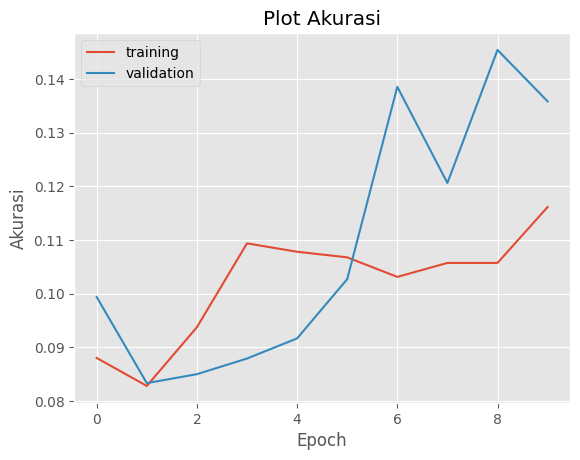

In [31]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), history.history["accuracy"], label="training")
plt.plot(np.arange(0, 10), history.history["val_accuracy"], label="validation")
plt.title("Plot Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [29]:
model.save('./model/cnnV1.h5')

### Pretrained Layer mobilenetV2

In [164]:
tf.keras.backend.clear_session()

mobilenetV2 = Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-feature-vector/2", input_shape=(224, 224, 3), trainable=False),
    layers.Dense(class_num, activation='softmax')
])

mobilenetV2.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss=keras.losses.CategoricalCrossentropy(),
                            metrics=['accuracy'])

mobilenetV2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1664)              3766048   
                                                                 
 dense (Dense)               (None, 12)                19980     
                                                                 
Total params: 3786028 (14.44 MB)
Trainable params: 19980 (78.05 KB)
Non-trainable params: 3766048 (14.37 MB)
_________________________________________________________________


In [165]:
epoch_num = 10
history_mobilenetV2 = mobilenetV2.fit(
    X_train, 
    epochs=10,
    batch_size=32,
    validation_data=X_valid,
    callbacks=myCallback()
)

Epoch 1/10
600/600 [==============================] - 82s 129ms/step - loss: 0.3389 - accuracy: 0.8998 - val_loss: 0.1746 - val_accuracy: 0.9463
Epoch 2/10
600/600 [==============================] - 80s 132ms/step - loss: 0.1677 - accuracy: 0.9471 - val_loss: 0.1612 - val_accuracy: 0.9483
Epoch 3/10
600/600 [==============================] - 80s 133ms/step - loss: 0.1280 - accuracy: 0.9596 - val_loss: 0.1461 - val_accuracy: 0.9560
Epoch 4/10
600/600 [==============================] - 81s 134ms/step - loss: 0.1002 - accuracy: 0.9708 - val_loss: 0.1702 - val_accuracy: 0.9458
Epoch 5/10
600/600 [==============================] - 83s 139ms/step - loss: 0.0838 - accuracy: 0.9745 - val_loss: 0.1599 - val_accuracy: 0.9494
Epoch 6/10
600/600 [==============================] - 82s 137ms/step - loss: 0.0698 - accuracy: 0.9803 - val_loss: 0.1828 - val_accuracy: 0.9460
Epoch 7/10
600/600 [==============================] - 82s 136ms/step - loss: 0.0571 - accuracy: 0.9848 - val_loss: 0.1683 - val_ac

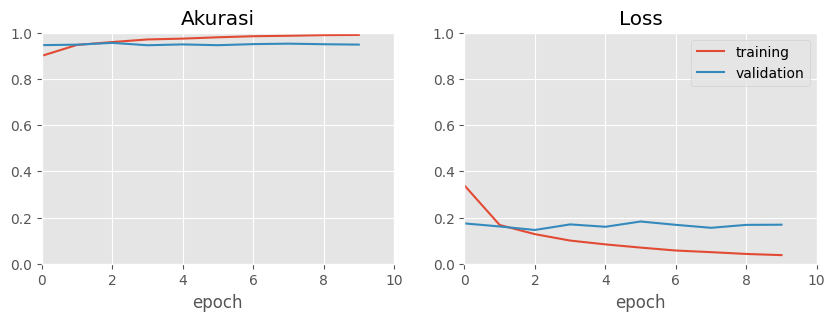

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].set(xlabel='epoch', title="Akurasi", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history_mobilenetV2.history["accuracy"], label="training")
axs[1].set(xlabel='epoch', title="Loss", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history_mobilenetV2.history["val_accuracy"], label="validation")
axs[1].plot(history_mobilenetV2.history["loss"], label="training")
axs[1].plot(history_mobilenetV2.history["val_loss"], label="validation")
plt.legend()

In [167]:
eva = mobilenetV2.evaluate(X_valid)
print(f"Model Evaluasi (Akurasi) : {eva[1]*100:.2f}%")
print(f"Model Evaluasi (loss)    : {eva[0]*100:.2f}%")

150/150 [==============================] - 11s 74ms/step - loss: 0.1689 - accuracy: 0.9485
Model Evaluasi (Akurasi) : 94.85%
Model Evaluasi (loss)    : 16.89%


In [168]:
mobilenetV2.save('./model/mobilenetV2-140-224.h5')

### Pretrained Model MobileNetV2

In [29]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenetv2 = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [38]:
# Freeze Layer
for layer in mobilenetv2.layers:
    layer.trainable = False

# Adding Layers
class_num = len(animal_dict.keys())
model_mobilenet = Sequential([
    mobilenetv2,
    Conv2D(32, (7, 7),padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(class_num, activation='softmax')
])

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

model_mobilenet.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 32)          2007072   
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 3, 3, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 288)               0         
                                                                 
 dense_10 (Dense)            (None, 12)                3468      
                                                                 
Total params: 4268524 (16.28 MB)
Trainable params: 20

In [ ]:
epoch_num = 10
history_mobilenet = model_mobilenet.fit(
    X_train, 
    epochs=30,
    batch_size=64,
    validation_data=X_valid,
    callbacks=myCallback()
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].set(xlabel='epoch', title="Akurasi", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history_mobilenet.history["accuracy"], label="training")
axs[0].plot(history_mobilenet.history["val_accuracy"], label="validation")

axs[1].set(xlabel='epoch', title="Loss", xlim=(0,epoch_num), ylim=(0,1))
axs[1].plot(history_mobilenet.history["loss"], label="training")
axs[1].plot(history_mobilenet.history["val_loss"], label="validation")

plt.legend()

eva = model_mobilenet.evaluate(X_valid)
print(f"Model Evaluasi (Akurasi) : {eva[1]*100:.2f}%")
print(f"Model Evaluasi (loss)    : {eva[0]*100:.2f}%")

### Pretrained Model Resnet50

In [25]:
from keras.applications.resnet_v2 import ResNet50V2

resnet50V2 = ResNet50V2(
                weights='imagenet', 
                include_top=False,
                input_shape=(224, 224, 3),
                # pooling='max'
)

# resnet50V2.summary()

In [26]:
# Freeze Layer
for layer in resnet50V2.layers:
    layer.trainable = False

# Adding Layers
class_num = len(animal_dict.keys())
model_resnet = Sequential([
    resnet50V2,
    Conv2D(32, (7, 7),padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(class_num, activation='softmax')
])

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

model_resnet.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 32)          3211296   
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 3, 3, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 288)               0         
                                                                 
 dense_8 (Dense)             (None, 12)                3468      
                                                                 
Total params: 26779564 (102.16 MB)
Trainable params: 3214764 (12.26 MB)
Non-trainable params: 23564800 (89.89 MB)
______

In [ ]:
epoch_num = 10
history_resnet = model_resnet.fit(
    X_train, 
    epochs=30,
    batch_size=64,
    validation_data=X_valid,
    callbacks=myCallback()
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].set(xlabel='epoch', title="Akurasi", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history_resnet.history["accuracy"], label="training")
axs[0].plot(history_resnet.history["val_accuracy"], label="validation")

axs[1].set(xlabel='epoch', title="Loss", xlim=(0,epoch_num), ylim=(0,1))
axs[1].plot(history_resnet.history["loss"], label="training")
axs[1].plot(history_resnet.history["val_loss"], label="validation")

plt.legend()

In [ ]:
eva = model_resnet.evaluate(X_valid)
print(f"Model Evaluasi (Akurasi) : {eva[1]*100:.2f}%")
print(f"Model Evaluasi (loss)    : {eva[0]*100:.2f}%")

In [ ]:
model_resnet.save('./model/resnet50V2.h5')